# GAN

## GANとは

　Generative adversarial networks(敵対的生成ネットワーク)の略です。

現実には存在しない画像などを生成するために使用されます。

　GANはGenerator(生成ネットワーク)とDiscriminator(識別ネットワーク)の2つのネットワークから構成されます。

例えば画像生成を考えると、

- Generator は新たな画像を生成するためのネットワーク、
- Discriminaorは与えられた画層がGeneratorによって生成された画像か現実の画像かを識別するネットワーク

になります。

それぞれ、
- GeneratorはDiscriminatorに見破られないような画像を生成するように
- DiscriminatorはGeneratorが生成した画像を見破るように

学習を進めていきます。

学習が進むにつれ、Generatorが生成する画像はと現実の画像と見分けが困難なものになっていきます。


## GANの構造

Discriminator、Generator はそれぞれ個々にニューラルネットワークを構成します。

- Generatorはランダムな数値群(画像の種)を入力とし、画層を出力します。
- Discriminator は画像を入力とし、「本物」か「偽物」かの2値を出力します。

    <img src="fig/gan1.png" width="40%" alt="gan1">

学習時は、

- Discriminator の学習では、「偽物」ラベルを付けたGenerator の出力画像と「本物」ラベルを付けた現実の画像を混ぜて入力し、教師付き学習を行います。

    <img src="fig/gan2.png" width="50%" alt="gan2">

- Generator の学習では、Generator の出力が Discriminatorの入力となっているような学習用のネットワークを使用します。その上でDiscirminator の出力が全て「本物」になるようGeneratorの最適化を行います。

    <img src="fig/gan3.png" width="50%" alt="gan3">

- Discriminator の学習と Generator の学習を交互に繰り返し行います


## 実装

MNIST を「本物」データとして、GAN を使って「偽物」の手書き画像を作成してみます。

一般に GAN は処理時間が大きくなるので、今回はMNISTから何文字かだけ取り出すことにします。

In [1]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, fashion_mnist

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 画像サイズ
img_size = 28*28

### 使用する関数群の定義

In [14]:
# ランダムデータ作成(Generatorの種)
def make_random_data(n):
    return np.random.normal(size=(n, img_size)).astype('float32')

# 描画用
## データは値 0.0〜1.0 の img_size 個のリストを想定
def disp_fig3(fig, n=1):
    plt.figure(figsize=(10,20))
    for i in range(n):
        ax = plt.subplot(1,5,i+1)
        ax.imshow(fig[i].reshape(28, 28) * 255, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# mnist から指定された数字だけ読み出す
def read_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # 9 だけ取り出し
    train_data = x_train[(y_train == 9)].reshape(-1, img_size) / 255
    test_data = x_test[(y_test == 9)].reshape(-1, img_size) / 255
   
    # trainとtest をまとめる
    return np.vstack([train_data, test_data])

# Generator で 5個だけイメージを作り、表示
def disp_sample(generator, discriminator):
    n = 5
    gen_images = generator.generate_image(n)
    disp_fig3(gen_images, n)

### Generatorクラス

In [38]:
# Generator
class Generator:
    def __init__(self):
        units1 = 128
        units2 = 128

        model = Sequential()
        model.add(Dense(input_shape=(img_size,), units=units1, activation='tanh'))
        model.add(Dense(units=units2, activation='tanh'))
        model.add(Dense(units=img_size, activation='sigmoid'))
    
        # model.summary()
        self.model = model
    
    # イメージ作成
    def generate_image(self, n):
        random_data = make_random_data(n)
        return self.model.predict(random_data)

    # Discriminator学習用のデータ作成
    def get_discriminator_training_data(self, true_image):
        # Generator に真データと同数の偽データを作らせる
        false_image = self.generate_image(len(true_image))
        image = np.vstack([true_image, false_image])

        # 正解ラベル作成
        # label:  0->false,  1->true
        label = np.hstack([np.ones(len(true_image)), np.zeros(len(false_image))])

        # データとラベルをくっつける
        data = list(zip(image, label))
        # シャッフル
        np.random.shuffle(data)
        # データとラベルを分離
        image, label = zip(*data)
        return np.array(image), np.array(label)


### Discriminatorクラス

In [36]:
# Discriminator
class Discriminator:
    def __init__(self):
        units1 = 256
        units2 = 128
        model = Sequential()
        model.add(Dense(input_shape=(img_size,), units=units1, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(units=units2, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation="sigmoid"))

        # model.summary()
        self.model = model
    
    # 学習
    def train(self, generator, x_train, verbose=False):
        # 学習用データ
        ## 半分だけ Generator が作ったデータ
        x_disc_train, y_disc_train = generator.get_discriminator_training_data(x_train)

        # Discriminator を学習可能に
        self.model.trainable = True
        # trainable 変更後に complie
        self.model.compile(
            optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])
        
        # 学習
        hist1 = self.model.fit(
            x_disc_train,
            y_disc_train,
            epochs=1,
            batch_size=128,
            verbose=verbose,
        )
        return hist1

    # 判定
    def predict(self, x):
        return self.model.predict(x)
        

### Generator学習用のモデル

In [37]:
# Genarator 学習器
#   Generator と Discriminator を直列につなぐ
class Generator_trainer:
    gene_train_data_size = 10000
    ## 学習時のラベルはALL 1(本物)。Discriminator にすべて本物だと予測させたい
    y_gene_train = np.ones(gene_train_data_size)
 
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator

        model = Sequential()
        model.add(self.generator.model)
        model.add(self.discriminator.model)
    
        self.model = model
    
    # 学習
    def train(self, verbose=False):
       # 学習用データ
        ## 入力はランダムなデータ
        x_gene_train = make_random_data(self.gene_train_data_size)

       # Discriminator は学習しないように
        self.discriminator.model.trainable = False
        # trainable 変更後に complie
        self.model.compile(
            optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

        # 学習
        hist2 = self.model.fit(
            x_gene_train,
            self.y_gene_train,
            epochs=1,
            batch_size=128,
            verbose=verbose,
        )
        return hist2
        

### メインルーチン

In [39]:
#### メインルーチン

# 各変数準備
x_train = read_mnist()   # MNIST から 数字を取り出す

generator = Generator()
discriminator = Discriminator()
gene_trainer = Generator_trainer(generator, discriminator)


Epoch: 0 

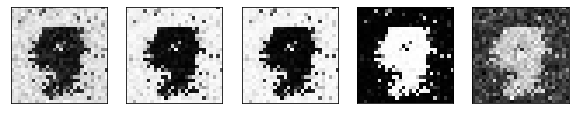

Epoch: 1 Epoch: 2 Epoch: 3 Epoch: 4 Epoch: 5 Epoch: 6 Epoch: 7 Epoch: 8 Epoch: 9 Epoch: 10 

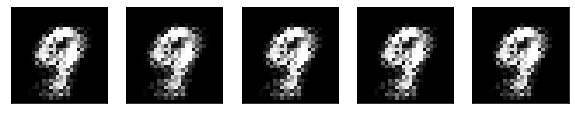

Epoch: 11 Epoch: 12 Epoch: 13 Epoch: 14 Epoch: 15 Epoch: 16 Epoch: 17 Epoch: 18 Epoch: 19 Epoch: 20 

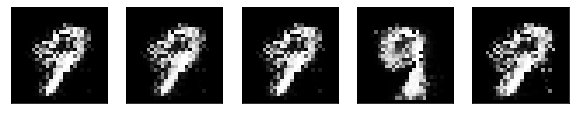

Epoch: 21 Epoch: 22 Epoch: 23 Epoch: 24 Epoch: 25 Epoch: 26 Epoch: 27 Epoch: 28 Epoch: 29 Epoch: 30 

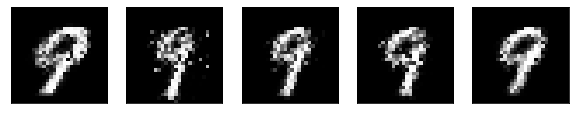

Epoch: 31 Epoch: 32 Epoch: 33 Epoch: 34 Epoch: 35 Epoch: 36 Epoch: 37 Epoch: 38 Epoch: 39 Epoch: 40 

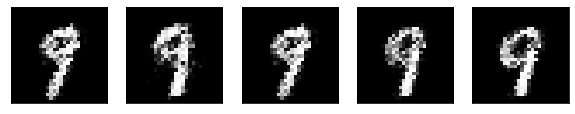

Epoch: 41 Epoch: 42 Epoch: 43 Epoch: 44 Epoch: 45 Epoch: 46 Epoch: 47 Epoch: 48 Epoch: 49 Epoch: 50 

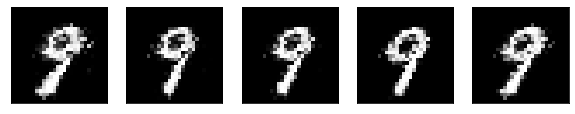

Epoch: 51 Epoch: 52 Epoch: 53 Epoch: 54 Epoch: 55 Epoch: 56 Epoch: 57 Epoch: 58 Epoch: 59 Epoch: 60 

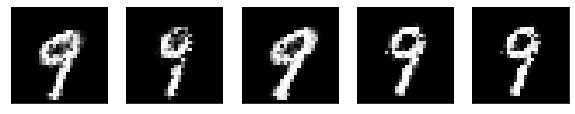

Epoch: 61 Epoch: 62 Epoch: 63 Epoch: 64 Epoch: 65 Epoch: 66 Epoch: 67 Epoch: 68 Epoch: 69 Epoch: 70 

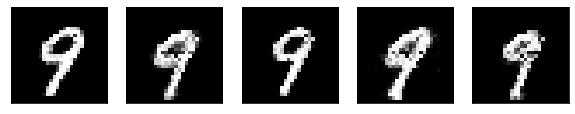

Epoch: 71 Epoch: 72 Epoch: 73 Epoch: 74 Epoch: 75 Epoch: 76 Epoch: 77 Epoch: 78 Epoch: 79 Epoch: 80 

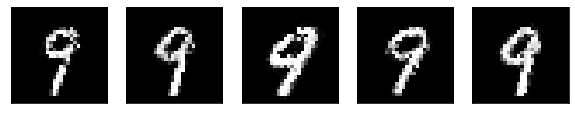

Epoch: 81 Epoch: 82 Epoch: 83 Epoch: 84 Epoch: 85 Epoch: 86 Epoch: 87 Epoch: 88 Epoch: 89 Epoch: 90 

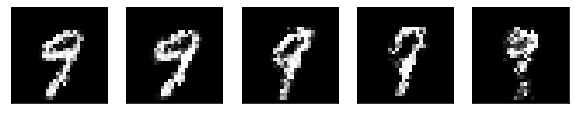

Epoch: 91 Epoch: 92 Epoch: 93 Epoch: 94 Epoch: 95 Epoch: 96 Epoch: 97 Epoch: 98 Epoch: 99 

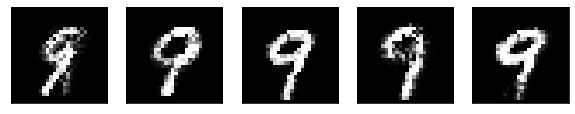

In [40]:
# 学習
for i in range(100):
    print("Epoch:", i, end=' ')
    # Discriminator 学習
    discriminator.train(generator, x_train)
    # Generator 学習
    gene_trainer.train()

    # 画像を作って表示させてみる
    if i % 10 == 0:
        disp_sample(generator, discriminator)
# 最後に表示
disp_sample(generator, discriminator)

#### モデルの保存

In [ ]:
gene_trainer.model.save('gene_trainer.h5')
discriminator.model.save('discriminator.h5')
generator.model.save('generator.h5')